# Wikipedia articles recommend system
<p> <img src="files/img/wiki_logo.png" style="width:500px">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import Pipeline

from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer, MaxAbsScaler

## 1. Load data
* The size dataset is about 3 Gigabytes
* The index of the dataframe is the unique article name
* The column are the content for each article, which essentially is a collection of words 
* There are 463819 wilipedia articles in the dataset

In [2]:
%%time
documents = pd.read_csv('datasets/wikipedia pages.csv', header=None, index_col=0)

Wall time: 26.9 s


In [3]:
documents.head()

,1
0,
wikipedia-23885690,Research Design and Standards Organization T...
wikipedia-23885928,The Death of Bunny Munro The Death of Bunny ...
wikipedia-23886057,Management of prostate cancer Treatment for ...
wikipedia-23886425,Cheetah reintroduction in India Reintroducti...
wikipedia-23886491,Langtang National Park The Langtang National...


#### Get the titles of the articles

In [4]:
titles = documents.index.values

In [5]:
titles

array(['wikipedia-23885690', 'wikipedia-23885928', 'wikipedia-23886057',
       ..., 'wikipedia-23012828', 'wikipedia-23012903',
       'wikipedia-23013130'], dtype=object)

### Pick the 50th row and expand the content

In [6]:
pd.set_option('display.max_colwidth', -1)

In [7]:
documents.iloc[50,:]

1     Conditional probability  In probability theory, a conditional probability is the probability that an event will occur, when another event is known to occur or to have occurred. If the events are "A" and "B" respectively, this is said to be "the probability of "A" given "B"". It is commonly denoted by "P"("A"|"B"), or sometimes "P"("A"). "P"("A"|"B") may or may not be equal to "P"("A"), the probability of "A". If they are equal, "A" and "B" are said to be independent. For example, if a coin is flipped twice, "the outcome of the second flip" is independent of "the outcome of the first flip". In the Bayesian interpretation of probability, the conditioning event is interpreted as evidence for the conditioned event. That is, "P"("A") is the probability of "A" before accounting for evidence "E", and "P"("A"|"E") is the probability of "A" having accounted for evidence "E". Definition. Conditioning on an event. Kolmogorov definition. Given two events "A" and "B" with "P"("B") > 0, the co

### Check the size of the dataframe

In [8]:
documents.shape

(463819, 1)

In [9]:
documents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 463819 entries, wikipedia-23885690 to wikipedia-23013130
Data columns (total 1 columns):
1    463819 non-null object
dtypes: object(1)
memory usage: 27.1+ MB


## 2. Convert data into sparse matrix
* The dataset is not in the format which can be used to train our model
* We need to convert the dataset to bag-of-words
* Due to the large size of the dataset, in order to improve the train speed, what we need is sparse matrix
* In the this section, we'll convert the dataset into sparse matrix

### Convert the first column of the dataframe to be a sparse matrix

#### Create TfidfVectorizer

In [10]:
# Create a TfidfVectorizer: tfidf
tfidf = TfidfVectorizer()

In [11]:
%%time
# Apply fit_transform to document: csr_mat
csr_mat = tfidf.fit_transform(documents.iloc[:, 0])

Wall time: 6min 59s


In [12]:
type(csr_mat)

scipy.sparse.csr.csr_matrix

### Check the vocaculary of the sparse matrix
* The vocabulary contains 2107645 words

In [13]:
csr_mat.shape

(463819, 2107645)

In [14]:
# Vocabulary summarize
tfidf.vocabulary_

{'research': 1509746,
 'design': 497473,
 'and': 146276,
 'standards': 1692154,
 'organization': 1314167,
 'the': 1780273,
 'organisation': 1314076,
 'rdso': 1492794,
 'is': 870680,
 'an': 143451,
 'iso': 873258,
 '9001': 75188,
 'development': 500991,
 'under': 1858377,
 'ministry': 1167051,
 'of': 1296133,
 'railways': 1479038,
 'india': 851110,
 'which': 1945453,
 'functions': 670285,
 'as': 181050,
 'technical': 1763219,
 'adviser': 103093,
 'consultant': 429688,
 'to': 1802012,
 'railway': 1479030,
 'board': 282957,
 'zonal': 2007580,
 'production': 1437803,
 'units': 1862921,
 'rites': 1524132,
 'ircon': 868733,
 'international': 862212,
 'in': 848291,
 'respect': 1510784,
 'standardisation': 1692125,
 'equipment': 592757,
 'problems': 1436697,
 'related': 1504141,
 'construction': 429515,
 'operation': 1309997,
 'maintenance': 1092962,
 'history': 799265,
 'enforce': 584906,
 'co': 411765,
 'ordination': 1313314,
 'between': 257093,
 'various': 1886537,
 'systems': 1736967,
 'br

## 3. Clustering Wikipedia pages
* TruncatedSVD is able to perform PCA on sparse arrays in csr_matrix format, such as word-frequency arrays
* Combine knowledge of TruncatedSVD and k-means to cluster some popular pages from Wikipedia
* The word-frequency matrix has been precomputed, so there's no need for a TfidfVectorizer

### Create SVD and KMenas
* Use TruncatedSVD to perform feature reduction
* Use KMeans to cluster wikipedia articles

In [15]:
# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=100)

In [16]:
# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=50)

### Build pipeline

In [17]:
steps = [('svd', svd), 
         ('kmeans', kmeans)]
pipeline = Pipeline(steps)

### Fit the pipeline

In [18]:
%%time
# Fit the pipeline to articles
pipeline.fit(csr_mat)

Wall time: 21min 34s


Pipeline(memory=None,
     steps=[('svd', TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

### Calculate the cluster labels

In [19]:
%%time
# Calculate the cluster labels: labels
labels_50 = pipeline.predict(csr_mat)

Wall time: 28.5 s


In [20]:
len(labels_50)

463819

### Create a DataFrame aligning labels and titles

In [21]:
# Create a DataFrame aligning labels and titles: df
df_50 = pd.DataFrame({'label': labels_50, 'article': titles})

In [22]:
# Display df sorted by cluster label
print(df_50.sort_values('label'))

                   article  label
59188   wikipedia-652948    0    
281336  wikipedia-1164322   0    
25272   wikipedia-4112395   0    
433036  wikipedia-24953689  0    
231493  wikipedia-16380007  0    
189096  wikipedia-6328      0    
404389  wikipedia-20251487  0    
366885  wikipedia-25146     0    
252306  wikipedia-6847263   0    
433051  wikipedia-25110410  0    
231485  wikipedia-16306870  0    
65508   wikipedia-5750839   0    
79106   wikipedia-1701432   0    
65504   wikipedia-5750711   0    
159075  wikipedia-5940610   0    
171876  wikipedia-163617    0    
433068  wikipedia-1810640   0    
189119  wikipedia-5361      0    
148588  wikipedia-1484748   0    
433075  wikipedia-1810753   0    
305904  wikipedia-7611849   0    
433086  wikipedia-1810903   0    
333712  wikipedia-1638459   0    
79117   wikipedia-1673634   0    
48494   wikipedia-1255728   0    
48496   wikipedia-1255740   0    
148577  wikipedia-1484541   0    
112073  wikipedia-488743    0    
25231   wikipe

#### Check the 50th article
* The article should have the title wikipedia-24104134
* We can see the label for this article is 3

In [23]:
df_50.iloc[50, :]

article    wikipedia-24104134
label      20                
Name: 50, dtype: object

#### Check for other article belongs to label 20

In [54]:
df_50[df_50.label==20]

,article,label
49,wikipedia-24104095,20
50,wikipedia-24104134,20
88,wikipedia-24038774,20
188,wikipedia-217647,20
305,wikipedia-235451,20
328,wikipedia-226943,20
385,wikipedia-219370,20
437,wikipedia-233807,20
447,wikipedia-230487,20
448,wikipedia-230488,20


#### Pick articles with label 20
* We pick several articles to see if the topic is the same

In [25]:
documents.iloc[49,:]

1     Cartesian product  In mathematics, a Cartesian product is a mathematical operation which returns a set (or product set) from multiple sets. That is, for sets "A" and "B", the Cartesian product is the set of all ordered pairs where and . The simplest case of a Cartesian product is the Cartesian square, which returns a set from two sets. A table can be created by taking the Cartesian product of a set of rows and a set of columns. If the Cartesian product is taken, the cells of the table contain ordered pairs of the form . A Cartesian product of "n" sets can be represented by an array of "n" dimensions, where each element is an "n"-tuple. An ordered pair is a 2-tuple. The Cartesian product is named after René Descartes, whose formulation of analytic geometry gave rise to the concept. Examples. A deck of cards. An illustrative example is the Standard 52-card deck. The standard playing card ranks {Ace, King, Queen, Jack, 10, 9, 8, 7, 6, 5, 4, 3, 2} form a 13 element-set. The card suit

In [26]:
documents.iloc[88,:]

1     1964 PRL symmetry breaking papers  In 1964 three teams proposed related but different approaches to explain how mass could arise in local gauge theories. These three, now famous, papers were written by Robert Brout and François Englert, Peter Higgs, and Gerald Guralnik, C. Richard Hagen, and Tom Kibble, and are credited with the theory of the Higgs mechanism and the prediction of the Higgs field and Higgs boson. Together, these provide a theoretical means by which Goldstone's theorem (a problematic limitation affecting early modern particle physics theories) can be avoided. They show how gauge bosons can acquire non-zero masses as a result of spontaneous symmetry breaking within gauge invariant models of the universe. As such, these form the key element of the electroweak theory that forms part of the Standard Model of particle physics, and of many models, such as the Grand Unified Theory, that go beyond it. The papers that introduce this mechanism were published in "Physical Rev

### Conclution: 
* The 50th article we pick has the topic on math, it belongs to label 41
* We checked two other articles belong to label 41, article 49th and article 88
* Both 49th and 88th articles are about math or academia topics which is similar to article 50th
* We can see the cluster we build is working well
* Since we have 463819 articels and we make them into 50 categories, the number of cluster is still relative small compared to the number of articles
* We can expect with the number of clusters increased, the similarity of articles in each cluster will be increased, but at the same time, the computational cost will be increased as well, so it is a tradeoff
* Next we wil use the inertia to determin what is the best number of clusters we need

# 4.  Determin the best number of clusters

### Check the current inertia

In [27]:
kmeans.inertia_

21337.70868226223

### Select the optimal number of clusters

In [28]:
ks = np.arange(50, 550, 50)

In [29]:
ks

array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])

In [30]:
%%time
inertias = []

for k in ks:
    # Create a TruncatedSVD instance: svd
    svd = TruncatedSVD(n_components=100)
    # Create a KMeans instance: kmeans
    kmeans = KMeans(n_clusters=k)
    
    steps = [('svd', svd), 
         ('kmeans', kmeans)]
    pipeline = Pipeline(steps)
    
    # Fit the pipeline to articles
    pipeline.fit(csr_mat)
    
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)   

Wall time: 15h 1min 33s


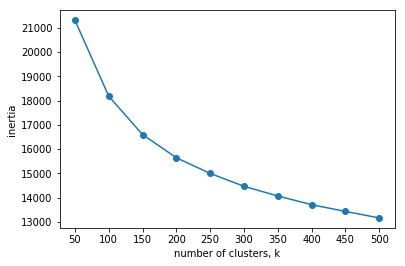

In [31]:
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### Conclusion: It takes 14.5 hours to draw inertia cureve for 10 different number of clusters. From the cureve, we could see strarting from n_clusters = 200, the inertia start decreasing slowly, thus 200 would be a good cluster number. 

# 5. Rebild the pipeline use the 200 clusters

### Choose number of clusters to be 200

In [32]:
# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=100)

In [33]:
# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=200)

### Build pipeline

In [34]:
steps = [('svd', svd), 
         ('kmeans', kmeans)]
pipeline = Pipeline(steps)

### Fit the pipeline

In [35]:
%%time
# Fit the pipeline to articles
pipeline.fit(csr_mat)

Wall time: 1h 3min 25s


Pipeline(memory=None,
     steps=[('svd', TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=200, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

### Calculate the cluster labels

In [36]:
%%time
# Calculate the cluster labels: labels
labels = pipeline.predict(csr_mat)

Wall time: 25.4 s


In [37]:
len(labels)

463819

### Create a DataFrame aligning labels and titles

In [38]:
# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'article': titles})

In [39]:
# Display df sorted by cluster label
print(df.sort_values('label'))

                   article  label
198670  wikipedia-35397160  0    
258484  wikipedia-38178274  0    
19498   wikipedia-1791585   0    
63198   wikipedia-3131023   0    
25470   wikipedia-7925763   0    
25469   wikipedia-7925760   0    
19501   wikipedia-1791649   0    
40007   wikipedia-1119634   0    
19504   wikipedia-5116593   0    
101562  wikipedia-938212    0    
196932  wikipedia-2321513   0    
63149   wikipedia-3104806   0    
196916  wikipedia-2321273   0    
258538  wikipedia-38305645  0    
196894  wikipedia-2320860   0    
196849  wikipedia-2335217   0    
353562  wikipedia-7834942   0    
85654   wikipedia-2253528   0    
313902  wikipedia-10122372  0    
419224  wikipedia-145064    0    
258332  wikipedia-7900183   0    
14027   wikipedia-7400213   0    
39946   wikipedia-1084633   0    
197189  wikipedia-2307768   0    
353349  wikipedia-7686164   0    
63309   wikipedia-3113624   0    
152268  wikipedia-4669470   0    
101582  wikipedia-938517    0    
39961   wikipe

### Check the 10000th article
* This article is about a singer
* The article should have the title wikipedia-12144898
* We can see the label for this article is 173

In [40]:
documents.iloc[10000,:]

1     Alex Ebert  Alex Ebert (born May 12, 1978) is an American singer-songwriter. He is best known for being the lead singer and songwriter for the American bands Ima Robot and Edward Sharpe and the Magnetic Zeros. Early life. Ebert was born in Los Angeles in 1978, the son of Michael Ebert, a psychotherapist. His mother, Lisa Richards, is an actress. His father would often take the family on long car trips through the desert. On one such trip, his mother shot footage of his father chanting in the desert, cradling Alex's baby sister Gabi, which would one day become a part of the video for the Edward Sharpe and the Magnetic Zeros song "Desert Song". His grandfather Carl Ebert had been Intendant of Deutsche Oper, Berlin; he also was a famous Actor trained by Max Reinhardt. His full birth name is Alexander Michael Tahquitz Ebert. His father took one of his son's names, Tahquitz, from his favorite climbing rock. Alex later on discovered that the name means "demon" in a Native American lang

In [41]:
df.iloc[10000, :]

article    wikipedia-12144898
label      174               
Name: 10000, dtype: object

### Check total number of articles with label 174

In [57]:
df[df.label==174].count()

article    2884
label      2884
dtype: int64

### Check for other article belongs to label 174

In [55]:
df[df.label==174]

,article,label
129,wikipedia-24061473,174
218,wikipedia-225040,174
497,wikipedia-229023,174
561,wikipedia-232142,174
663,wikipedia-23369262,174
665,wikipedia-23369739,174
963,wikipedia-20110751,174
1626,wikipedia-299437,174
1683,wikipedia-292822,174
2481,wikipedia-652663,174


### Check other articles under label 173

In [43]:
documents.iloc[129,:]

1     Seungri  Lee Seung-hyun (Hangul: 이승현; born December 12, 1990), known by his stage name Seungri or V. I. (Hangul: 승리; lit. "victory"), is a South Korean singer, songwriter, dancer, actor, and model, who is best known as a member of South Korean boy group Big Bang. Seungri released his first album "VVIP" in 2011. Along with his native Korean, he speaks fluent Japanese and conversational English. Biography. Pre Debut. Before joining the group, in his hometown, Gwangju, he was the leader and part of the dance group "II Hwa". Seungri is known for his dance skills.  He first appeared on television on the reality television series "Let's Cokeplay: Mnet Battle Shinhwa", a show in which Shinhwa attempted to create a boy band that could be a "second Shinhwa". Although he was noticed for his dance skills, his lack of vocal skills led to him being eliminated. If he wasn't eliminated he would have debuted in "Battle" a group of 6 boys that each Shinhwa member picked out. themselves. He was la

In [44]:
documents.iloc[218,:]

1     William Orbit  William Orbit (born William Mark Wainwright, 15 December 1956) is an English musician, composer and record producer. In the early 1980s he formed synthpop act Torch Song with Laurie Mayer and Grant Gilbert. In 1987 he released the first of his Strange Cargo album series, containing ambient music. Towards the end of the 1990s Orbit started to work with bigger name artists, producing songs on "Ray of Light" and "Music" by Madonna, "13" and "Think Tank" by Blur and "Saints and Sinners" by All Saints. His work with Madonna led him to win three Grammys. He worked again with Madonna on her 2012 album "MDNA" producing six songs. Biography. 1956–1980: Early life & first work. William Orbit was born William Wainwright in London's East End in 1956. His mother, of Italian and Swedish descent, and his father, from Yorkshire, were both schoolteachers. He does not have a formal education, having left school at 15 and being entirely self-taught. Aged 16, and living in a squat in 

### Check other articles under label 173

In [88]:
documents.iloc[497,:]

1     George Jones  George Glenn Jones (September 12, 1931 – April 26, 2013) was an American musician, singer and songwriter who achieved international fame for his long list of hit records as well as his distinctive voice and phrasing. He is generally regarded as one of the greatest vocalists in the history of country music. Country music scholar Bill C. Malone writes, "For the two or three minutes consumed by a song, Jones immerses himself so completely in its lyrics, and in the mood it conveys, that the listener can scarcely avoid becoming similarly involved." Merle Haggard wrote in "Rolling Stone" magazine that "His voice was like a Stradivarius violin: one of the greatest instruments ever made." During his life, Jones had more than 150 hits during his career, both as a solo artist and in duets with other artists.  Jones was also infamous for his alcoholism, cocaine addiction, missed concert dates (which inspired the moniker "No Show Jones") and general unmanageability. Jones' alco

### Conclusion: The cluster mechanism is working great. We randomly chose 10000th article which with the topic on siger or music. We tested the recommender system can successifully recommend us articles on other siger. 

# 6. Visualuzing the clustering 
* We usr t-SNE to visulize our clustering
* t-SNE can map samples from high dimension space to 2 or 3 dimensional space to visulize

## t-SNE model

In [45]:
model = TSNE(learning_rate=100)

## Dimention reduction on csr_mat
* The dimension of the sparse matrix can not exceed the memory to feed into t-SNE model
* Thus we need to do dimention reduction first

In [46]:
csr_mat_reduced = svd.fit_transform(csr_mat)

In [51]:
csr_mat_reduced.shape

(463819, 100)

csr_mat_reduced[0,:]

## fit_transform

In [47]:
%%time
transformed = model.fit_transform(csr_mat_reduced)

Wall time: 9h 57min 35s


## Scatter plot

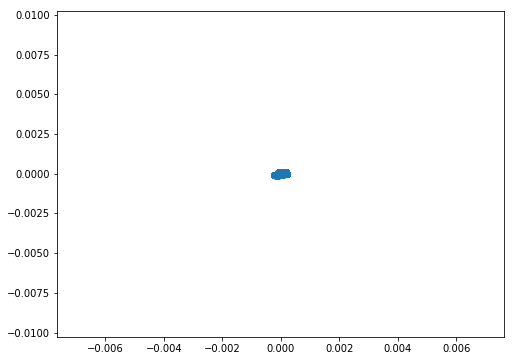

In [49]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6

xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)

### Conclusion: The clustering visualization using t-SNE takes 9h57mins, but it turns out t-SNE is not a very good tool in this case, since the cluters are aggregated in one spot. 

# 7. Recommend the most relavent article
* The previous model divide the 463,819 articles into 200 clusters
* But we can imagine there are still thousand articles in each cluster, e.g. the cluster with topic on singer has 2884 articles
* The question here is based on what the reader currently read, how can we recommend him/her the most similar article? In other words, the articles match his/her taste the best?
* In this section, we'll work on this issue
* NMF model is build, then we calculate the cosine similarities

## Build NMF model
* Since our clustering section has showed the optimis clusters are 200, thus in NMF model, we still assume 200 topics is the optimum, we make n_components=200

In [58]:
nmf = NMF(n_components=200)

## Fit and transform csr_mat

In [60]:
%%time
nmf_features = nmf.fit_transform(csr_mat)

Wall time: 12h 27min 6s


## NMF features

In [61]:
nmf_features

array([[2.24092055e-03, 2.12100211e-06, 0.00000000e+00, ...,
        0.00000000e+00, 3.16354760e-03, 0.00000000e+00],
       [1.19879142e-02, 3.48855842e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.31561463e-03],
       [8.25606679e-03, 1.41027685e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.25552952e-02, 0.00000000e+00, 1.02790949e-03, ...,
        0.00000000e+00, 4.50337516e-04, 8.92704490e-05],
       [6.41191146e-03, 1.36629961e-03, 1.63516674e-04, ...,
        0.00000000e+00, 0.00000000e+00, 8.73527883e-04],
       [3.90046045e-03, 7.58874615e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.80356242e-04]])

### NMF features have 463,819 rows, 200 columns

In [62]:
nmf_features.shape

(463819, 200)

## Build a Dataframe align NMF features with article titles

In [81]:
# Create a pandas DataFrame: df
nmf_features_df = pd.DataFrame(nmf_features, index=titles)
nmf_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
wikipedia-23885690,0.002241,0.000002,0.0,0.000029,0.000000,0.000000,0.000789,0.000311,0.0,0.000000,...,0.00000,0.001484,0.000000,0.00000,0.0,0.000000,0.000278,0.000000,0.003164,0.000000
wikipedia-23885928,0.011988,0.000349,0.0,0.000782,0.002373,0.000012,0.000784,0.000606,0.0,0.000000,...,0.00000,0.000440,0.000066,0.05391,0.0,0.000000,0.005732,0.000000,0.000000,0.001316
wikipedia-23886057,0.008256,0.000141,0.0,0.000000,0.000080,0.000009,0.000666,0.000000,0.0,0.000068,...,0.00683,0.000000,0.000000,0.00000,0.0,0.000072,0.000000,0.000000,0.000000,0.000000
wikipedia-23886425,0.010265,0.000339,0.0,0.000000,0.000000,0.000005,0.001306,0.000000,0.0,0.000000,...,0.00065,0.000000,0.000000,0.00000,0.0,0.000040,0.000000,0.000000,0.000029,0.000810
wikipedia-23886491,0.012532,0.000000,0.0,0.000000,0.000000,0.000009,0.001305,0.000000,0.0,0.000025,...,0.00000,0.000000,0.000752,0.00000,0.0,0.000347,0.000000,0.000289,0.000000,0.000000


## Extract most important feature for topic singler
* Five articles under this topic were selected
* For each, we extract the largest 5 features
* We summarize the most important feature for this topic

### Extract the number 10000th article 
* We extract the 5 largest NMF feature values
* NMF feature 3 has the highest value

In [83]:
nmf_features_df.iloc[10000].nlargest()

3      0.011719
199    0.008392
0      0.006777
4      0.006115
186    0.004589
Name: wikipedia-12144898, dtype: float64

### Extract the number 129th article 
* We extract the 5 largest NMF feature values
* NMF feature 3 has the highest value

In [84]:
nmf_features_df.iloc[129].nlargest()

3      0.015893
136    0.008098
0      0.005415
4      0.004887
153    0.004779
Name: wikipedia-24061473, dtype: float64

### Extract the number 218th article 
* We extract the 5 largest NMF feature values
* NMF feature 196 and 3 has the highest value

In [85]:
nmf_features_df.iloc[218].nlargest()

196    0.019522
3      0.019247
185    0.009334
24     0.008784
1      0.007322
Name: wikipedia-225040, dtype: float64

### Extract the number 497th article 
* We extract the 5 largest NMF feature values
* NMF feature 199 has the highest value

In [86]:
nmf_features_df.iloc[497].nlargest()

199    0.008756
0      0.008202
4      0.007452
1      0.007190
2      0.004924
Name: wikipedia-229023, dtype: float64

### Extract the number 561th article 
* We extract the 5 largest NMF feature values
* NMF feature 3 has the highest value

In [87]:
nmf_features_df.iloc[561].nlargest()

3      0.007677
0      0.005549
199    0.004779
7      0.002476
1      0.002411
Name: wikipedia-232142, dtype: float64

### Summary: Feature 3 and 199 have highest weights for single or musition topic

## Vocabulary

In [69]:
# Vocabulary summarize
vocabulary = tfidf.vocabulary_

In [70]:
vocabulary

{'research': 1509746,
 'design': 497473,
 'and': 146276,
 'standards': 1692154,
 'organization': 1314167,
 'the': 1780273,
 'organisation': 1314076,
 'rdso': 1492794,
 'is': 870680,
 'an': 143451,
 'iso': 873258,
 '9001': 75188,
 'development': 500991,
 'under': 1858377,
 'ministry': 1167051,
 'of': 1296133,
 'railways': 1479038,
 'india': 851110,
 'which': 1945453,
 'functions': 670285,
 'as': 181050,
 'technical': 1763219,
 'adviser': 103093,
 'consultant': 429688,
 'to': 1802012,
 'railway': 1479030,
 'board': 282957,
 'zonal': 2007580,
 'production': 1437803,
 'units': 1862921,
 'rites': 1524132,
 'ircon': 868733,
 'international': 862212,
 'in': 848291,
 'respect': 1510784,
 'standardisation': 1692125,
 'equipment': 592757,
 'problems': 1436697,
 'related': 1504141,
 'construction': 429515,
 'operation': 1309997,
 'maintenance': 1092962,
 'history': 799265,
 'enforce': 584906,
 'co': 411765,
 'ordination': 1313314,
 'between': 257093,
 'various': 1886537,
 'systems': 1736967,
 'br

### vocabulary is a dictionary object, the key is the word and value is the number of times that word appears

In [71]:
type(vocabulary)

dict

### Extract the keys

In [72]:
words = list(vocabulary.keys())

In [73]:
words

['research',
 'design',
 'and',
 'standards',
 'organization',
 'the',
 'organisation',
 'rdso',
 'is',
 'an',
 'iso',
 '9001',
 'development',
 'under',
 'ministry',
 'of',
 'railways',
 'india',
 'which',
 'functions',
 'as',
 'technical',
 'adviser',
 'consultant',
 'to',
 'railway',
 'board',
 'zonal',
 'production',
 'units',
 'rites',
 'ircon',
 'international',
 'in',
 'respect',
 'standardisation',
 'equipment',
 'problems',
 'related',
 'construction',
 'operation',
 'maintenance',
 'history',
 'enforce',
 'co',
 'ordination',
 'between',
 'various',
 'systems',
 'british',
 'indian',
 'conference',
 'association',
 'irca',
 'was',
 'set',
 'up',
 '1903',
 'it',
 'followed',
 'by',
 'establishment',
 'central',
 'office',
 'cso',
 '1930',
 'for',
 'preparation',
 'designs',
 'specifications',
 'however',
 'till',
 'independence',
 '1947',
 'most',
 'manufacture',
 'equipments',
 'entrusted',
 'foreign',
 'consultants',
 'after',
 'new',
 'called',
 'testing',
 'centre',
 'rtrc

## Build a Dataframe align NMF features and vocabulary

In [74]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(nmf.components_, columns=words)
components_df

,research,design,and,standards,organization,the,organisation,rdso,is,an,...,anpe,unédic,völkerrechtswidrige,volkskriegs,v3i2_neander,20marlin_e,assédic,employeur,assécic,calucaltion
0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000011,0.000000,0.000000,0.000000,0.000000,0.000024,0.000024,0.0,0.0,0.000000
3,0.000000,0.101061,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,0.047803,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
8,0.000000,3.081654,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
9,0.000000,0.395096,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


## The componets of NMF represent a topic
* We still use the singer or music topic
* The most important NMF features for this topic is NMF feature 3 and 199
* We check the NMF componnets 3 and 199

In [96]:
# Choose a component to check its topic
components_3 = components_df.iloc[4]

In [97]:
# Check the 5 largest values for this component
components_3.nlargest()

schwechten    25.489330
xerion        5.452780 
wtsl          2.434193 
zurs          2.317888 
sfrta         2.165215 
Name: 4, dtype: float64

In [92]:
# Choose a component to check its topic
components_199 = components_df.iloc[199]

In [93]:
# Check the 5 largest values for this component
components_199.nlargest()

khageshvara    3.821863
vāra           2.532791
iverin         1.508476
blume          1.190916
tiso4          0.678571
Name: 199, dtype: float64

### Summary: The topic for NMF components 3 and 199 are not obvious, this could caused by the n_components in NMF model which is 200 is too big, we need reduce this number to 20. More NMF components means the classification would be more accurate, but the trade off is the interpretable topic for each NMF component is more obscure. 

## Cosine similarities

### Versions of articles
* Similar articles have the same topics
* But it is not always the NMF feature values are examctly the same
* For instance, one version of a document mighy use very direct language, whereas other version might interleave the same content with meaningless chatter
* Meaningless chatter reduce the frequency of the topic words overall, which reduces the values of the NMF features representing the topics
* However, on a scatter plot of the NMF features, all these versions lie on a single line passing through the origin

### Cosine similarity
* Uses tht two angle between the two lines
* Higher values means higher simularity: cos 0 = 1
* Maximum value is 1, when angle is 0 
* $a \cdot b = |a| |b| \cos \theta$

### <font color='red'>similarity</font> = $\cos \theta$ = $\frac{a \cdot b}{|a| |b|}$

### Calculating the cosine similarities

#### Import the normalize function

In [184]:
from sklearn.preprocessing import normalize

#### Apply normalize function to the array of all NMF features
* <font color='red'>Normalize is applied on the **row direction**</font>
* By normalization, the norm of each row vector will be 1

In [98]:
norm_features = normalize(nmf_features)

In [99]:
norm_features.shape

(463819, 200)

#### Select article 10000

In [102]:
current_article = norm_features[10000, :]

#### Calculate the similarities

In [103]:
similarities = norm_features.dot(current_article)

In [104]:
print(similarities)

[0.0890565  0.11810327 0.29468139 ... 0.28773221 0.3030341  0.22716008]


### Label similarities with article titles

In [112]:
df_norm_features = pd.DataFrame(norm_features)
df_norm_features.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.136890,0.000130,0.0,0.001785,0.000000,0.000000,0.048209,0.018973,0.0,0.000000,...,0.000000,0.090671,0.000000,0.000000,0.0,0.000000,0.016978,0.000000,0.193250,0.000000
1,0.214307,0.006236,0.0,0.013977,0.042425,0.000213,0.014016,0.010827,0.0,0.000000,...,0.000000,0.007874,0.001178,0.963744,0.0,0.000000,0.102466,0.000000,0.000000,0.023519
2,0.641464,0.010957,0.0,0.000000,0.006220,0.000678,0.051750,0.000000,0.0,0.005252,...,0.530637,0.000000,0.000000,0.000000,0.0,0.005591,0.000000,0.000000,0.000000,0.000000
3,0.728479,0.024036,0.0,0.000000,0.000000,0.000322,0.092714,0.000000,0.0,0.000000,...,0.046148,0.000000,0.000000,0.000000,0.0,0.002834,0.000000,0.000000,0.002091,0.057488
4,0.724719,0.000000,0.0,0.000000,0.000000,0.000514,0.075454,0.000000,0.0,0.001440,...,0.000000,0.000000,0.043487,0.000000,0.0,0.020086,0.000000,0.016733,0.000000,0.000000


### Select ariticle 10000

In [113]:
current_article = df_norm_features.iloc[10000]

### Calculate cosine similarities

In [114]:
similarities = df_norm_features.dot(current_article)

In [115]:
similarities.shape

(463819,)

### Find the highest similarities with the current article

In [116]:
similarities.nlargest(7)

10000     1.000000
289033    0.917768
12155     0.916931
106320    0.915027
306492    0.913053
163168    0.909410
367116    0.909240
dtype: float64

### Check the articles most similar to article 10000

In [117]:
documents.iloc[289033]

1     Chris Rene  Christopher "Chris" Rene (born December 25, 1982) is an American singer-songwriter, musician and producer from Santa Cruz, California. He had been in a band called Diversion and also had a solo career, including the album "Soul'd Out". Chris auditioned for the first season of "The X Factor USA" with one of his original compositions "Young Homie" and was one of the finalists during season one, with L.A. Reid as his mentor. He finished third overall in the competition, behind winner Melanie Amaro and runner-up Josh Krajcik. He is most popular in New Zealand, with his single "Young Homie" reaching number one in the New Zealand charts. Early life. Christopher Rene was born to Joan René (née Sampson) and Rafael Leon "Googie" René. His father was a songwriter and jazz pianist in the 1950s and 1960s, and he has two brothers, Mike and Gabriel, and a sister, Gina. Gina is a singer featured on the Mean Girls and Step Up soundtracks, Gabriel is a record producer, and both are me

In [118]:
documents.iloc[12155]

1     Ol' Dirty Bastard  Russell Tyrone Jones (November 15, 1968Â â November 13, 2004), best known by his stage name Ol' Dirty Bastard (or ODB), was an American rapper and occasional producer. He was one of the founding members of the Wu-Tang Clan, a rap group primarily from Staten Island, New York that first rose to mainstream prominence with their 1993 debut album "Enter the Wu-Tang (36 Chambers)". After establishing the Wu-Tang Clan, Ol' Dirty Bastard went on to pursue a successful solo career and contributed as a rapper/producer for the Fugees. However, his professional success was hampered by frequent legal troubles, including incarceration. He died on November 13, 2004 of a drug overdose, two days before his 36th birthday. Prior to his death, Jones managed to record his third solo album, which has been repeatedly delayed and as of 2013 has not been released. Jones was often noted for his trademark microphone techniques and his "outrageously profane, free-associative rhymes deli

In [119]:
documents.iloc[106320]

1     Kid Cudi  Scott Mescudi (born January 30, 1984), better known by his stage name Kid Cudi ( , often stylized KiD CuDi), is an American hip-hop recording artist and actor from Cleveland, Ohio. A rapper, singer-songwriter, guitarist and record producer, Cudi is signed under Republic Records and his own imprint, Wicked Awesome Records. He first gained recognition after the release of his first official full-length project, a mixtape titled "A Kid Named Cudi" (2008). The mixtape caught the attention of American rapper-producer and record executive Kanye West, who subsequently signed Cudi to his GOOD Music label in late 2008. Cudi's association with West and the GOOD Music label, led him to prominence. In 2009, Cudi's debut single "Day 'n' Nite", reached the top five of the "Billboard" charts. "Day 'n' Nite" was included on the mixtape as well as Cudi's debut studio album ' (2009), which was certified Gold by the Recording Industry Association of America (RIAA). "The End of Day" also f

### Conclution: The above examles have demonstrated our model can smartly recommend readers the most relavent articles from 463819 wikipedia article database. 